In [748]:
import torch
import my_utils as mu
import pandas as pd
import torch.utils.data as data
from torch import nn
import numpy as np
from numpy import linalg

# Neural Networks ECS659P Revision Elliot Linsey

### Human Intelligence: 
* Skills - languages, chess, mathematical reasoning
* Cognition - perception, memory, judgement and reasoning
* Volition - The will, purpose, choice
* Emotion - affective intelligence
* Speed, efficiency and creativity of information processing

Still very far away from achieving a machine that contains these qualities! 

Gary Marcus - "Today's AI has been very successful in building systems that perform a single narrow goal extremely well!"

For example, playing chess or identifying dog breeds or any other kind of pattern recognition

### The Deep Learning Model

Similar in training to standard machine learning. We use labelled input training data to create predictions or classifications. 

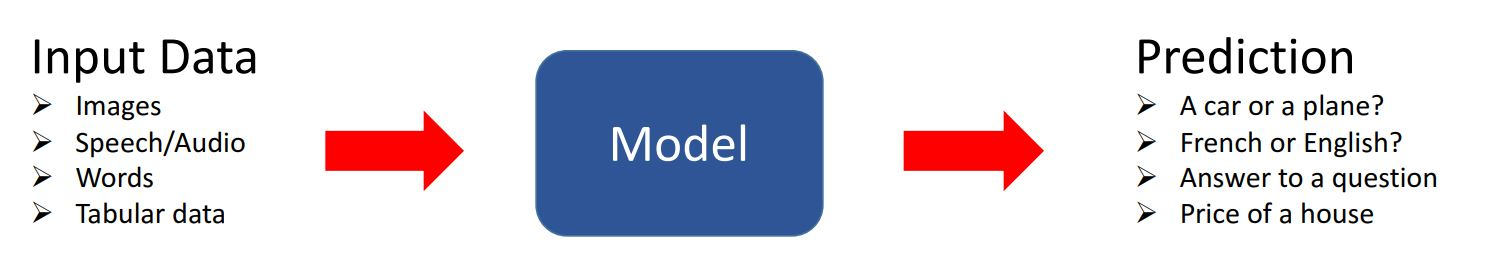

Within this, the model contains parameters (weights) which we compute functions or combinations of input data to make predictions.

For a linear regression model, the parameters would be: 

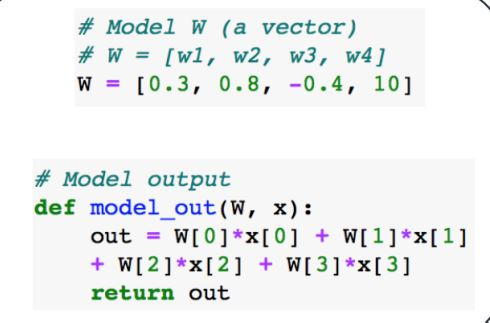

These are different to **Hyperparameters**.

### Training the Model

We always start with random values for our parameters, then update them so that our model predictions are as **close as possible** to the real outputs. 

We then define a **loss** function which determines how close to the true value our prediction is. 

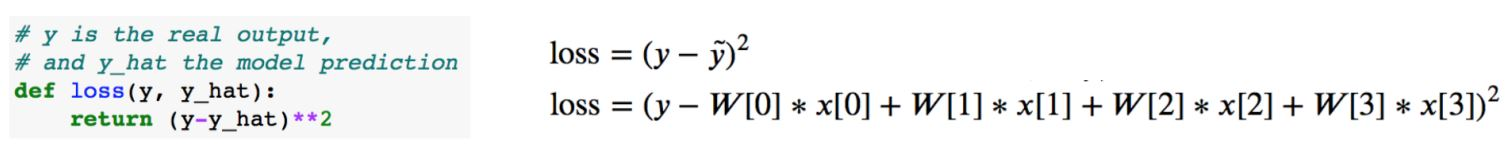

From here, **each parameter** is updated using the **derivative of the loss** in respect to that parameter.

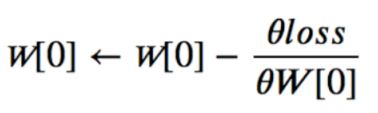

PyTorch takes care of this for us automatically, therefore I will skip any explicit maths to do with this subject (differential calculus) as I don't fully understand it (I have a music degree). 

## Multiple Linear Regression Example

Below is a dataframe full of fish with different species and some features regarding them (I have removed the species names). 

In [749]:
df = pd.read_csv('Fish.csv')
df = df.drop(columns='Species',axis=1)
df

,Weight,Length1,Length2,Length3,Height,Width
0,242.0,23.2,25.4,30.0,11.5200,4.0200
1,290.0,24.0,26.3,31.2,12.4800,4.3056
2,340.0,23.9,26.5,31.1,12.3778,4.6961
3,363.0,26.3,29.0,33.5,12.7300,4.4555
4,430.0,26.5,29.0,34.0,12.4440,5.1340
...,...,...,...,...,...,...
154,12.2,11.5,12.2,13.4,2.0904,1.3936
155,13.4,11.7,12.4,13.5,2.4300,1.2690
156,12.2,12.1,13.0,13.8,2.2770,1.2558
157,19.7,13.2,14.3,15.2,2.8728,2.0672


I have normalised all the data using z-score normalisation. This is because using the original data resulted in loss values that were too high to be processed. (I am not 100% sure if this has to be done for every problem if the values are large?)

In [750]:
df_zscore = (df - df.mean())/df.std()
df_zscore

,Weight,Length1,Length2,Length3,Height,Width
0,-0.436692,-0.304825,-0.281414,-0.105686,0.594700,-0.235784
1,-0.302606,-0.224797,-0.197430,-0.002329,0.818674,-0.066369
2,-0.162933,-0.234801,-0.178767,-0.010942,0.794830,0.165271
3,-0.098683,0.005285,0.054522,0.195772,0.877001,0.022550
4,0.088479,0.025292,0.054522,0.238837,0.810275,0.425028
...,...,...,...,...,...,...
154,-1.078631,-1.475242,-1.513179,-1.535458,-1.605287,-1.793735
155,-1.075279,-1.455235,-1.494516,-1.526845,-1.526056,-1.867646
156,-1.078631,-1.415221,-1.438527,-1.501006,-1.561752,-1.875476
157,-1.057680,-1.305181,-1.317216,-1.380422,-1.422748,-1.394163


I generate the optimum weights using the Least Squares method so that my models results can be evaluated to them. 

In [751]:
feats_num = np.array(df_zscore.iloc[::,-2:].values)
labs_num = np.array(df_zscore.iloc[::,0].values)
#feats_num

In [752]:
A = np.column_stack([np.ones(len(df_zscore)),feats_num])
A[:5]

array([[ 1.        ,  0.59469968, -0.23578397],
       [ 1.        ,  0.8186739 , -0.06636925],
       [ 1.        ,  0.79482997,  0.16527098],
       [ 1.        ,  0.87700051,  0.02254976],
       [ 1.        ,  0.81027486,  0.42502837]])

The results of the Least Squares solution, note the format is (b, w0, w1)

In [753]:
true_w = np.dot(np.dot(np.linalg.inv(np.dot(A.T, A)), A.T), labs_num)
print('optimum weights = ' + str(true_w))

optimum weights = [-6.58327559e-16  5.77667043e-02  8.40704482e-01]


For pytorch to work, the inputs have to be tensors. Specifying dtype=torch.float32 removes the little popup at the end telling you what data type each tensor is. 

**Important note about vectors**, a column vector has dimensions of (in this example for labels) [159,1]. That is the dimension created below using reshape(159,1). A dimension of just [159] is not a proper column or row vector. A row vector being [1,159]. 

When it comes to calculating the loss using the y_hat vector and original y vector, they need to be the same shape. y_hat will be in dimension of a column vector after the net is applied so [159,1] (or different depending on batch size fed in). Therefore, the original y vector should be reshaped into that same dimension.

In [754]:
feats = torch.tensor(df_zscore.iloc[::,-2:].values).to(dtype=torch.float32)
labs = torch.tensor(df_zscore.iloc[::,0].values).to(dtype=torch.float32).reshape(159,1)
labs[:5]

tensor([[-0.4367],
        [-0.3026],
        [-0.1629],
        [-0.0987],
        [ 0.0885]])

### Creating Dataset

We can use the inbuilt pytorch TensorDataset function to join both our features and labels into a single dataset. This can then be split into train and test iterations if needed. For this problem, we shall simply use the whole original dataset. 

We then need to create a DataLoader object that can be iterated through, this also requires a batch size (which is a hyperparameter that can be altered and will potentially change results achieved). The batch size is the number of samples you want to send through the net at a time until an epoch (complete run through of the dataset) is completed. 

### Minibatch Stochastic Gradient Descent

How batches are used within gradient descent should be understood by the practitioner.

**Batch Gradient Descent**: This is when the entire dataset is used by a network to update the model parameters. This is very slow as we have to wait for the full dataset to be processed before updating the parameters. 

**Stochastic Gradient Descent**: This is when the batch size is set to 1. Sometimes known as **online gradient descent** due to it being analogous to a stream of data being fed in one sample at a time. 

**Minibatch Stochastic Gradient Descent**: When the batch size is set *between* 1 and the full dataset. The parameter weights are updated after every batch. 

Some advantages to smaller batch sizes: 
* Smaller batches offer more noise to the data, creating a regularising effect and lower generalisation error
* They reduce amount of memory needed to allocate to the processor during training

Minibatch Stochastic Gradient Descent Method: 
* Select a random sample of size $\beta$ from our dataset
* Compute the derivative of the average loss with respect to our parameters for the batch
* Multiply this gradient by our learning rate $\eta$, then subtract this resulting term from our existing parameters to update them

In [755]:
dataset = data.TensorDataset(feats,labs)
train_iter, test_iter = data.random_split(dataset,[109,50],generator=torch.Generator().manual_seed(42))
batch_size = 20
train_iter,test_iter = data.DataLoader(train_iter,batch_size),data.DataLoader(test_iter,batch_size)
data_iter = data.DataLoader(dataset,batch_size)
print(dataset[0])

(tensor([ 0.5947, -0.2358]), tensor([-0.4367]))


In [756]:
next(iter(data_iter))


[tensor([[ 0.5947, -0.2358],
         [ 0.8187, -0.0664],
         [ 0.7948,  0.1653],
         [ 0.8770,  0.0225],
         [ 0.8103,  0.4250],
         [ 1.0805,  0.3025],
         [ 1.2152,  0.5107],
         [ 0.8630,  0.1617],
         [ 1.1744,  0.2529],
         [ 1.2262,  0.3215],
         [ 1.2346,  0.4074],
         [ 1.2599,  0.2356],
         [ 1.1171, -0.0294],
         [ 1.1530,  0.3887],
         [ 1.3960,  0.4469],
         [ 1.5088,  0.6896],
         [ 1.3740,  0.5148],
         [ 1.3921,  0.4627],
         [ 1.5543,  0.4249],
         [ 1.2838,  0.7771]]),
 tensor([[-0.4367],
         [-0.3026],
         [-0.1629],
         [-0.0987],
         [ 0.0885],
         [ 0.1443],
         [ 0.2840],
         [-0.0233],
         [ 0.1443],
         [ 0.2840],
         [ 0.2142],
         [ 0.2840],
         [ 0.2840],
         [-0.1629],
         [ 0.5634],
         [ 0.5634],
         [ 0.8427],
         [ 0.8427],
         [ 0.5913],
         [ 0.7030]])]

In [757]:
num_inputs,num_outputs = 2,1
net = nn.Linear(num_inputs,num_outputs)

In [758]:
def init_weights(m):
    if isinstance(m, nn.Linear): # by checking the type we can init different layers in different ways
        torch.nn.init.kaiming_normal_(m.weight)
        torch.nn.init.zeros_(m.bias)

In [759]:
net.apply(init_weights)

Linear(in_features=2, out_features=1, bias=True)

In [760]:
optimizer = torch.optim.SGD(net.parameters(),lr=0.1)
loss = nn.MSELoss()
num_epochs=20

In [761]:
X,y = next(iter(data_iter))
X.shape
y.shape

torch.Size([20, 1])

In [762]:
for epoch in range(num_epochs):
    for X,y in data_iter:
        y_hat = net(X)
        l = loss(y_hat,y)
        optimizer.zero_grad()
        l.backward()
        optimizer.step()
    l = loss(net(feats),labs)
    print(f'epoch {epoch+1},loss {l:f}')

epoch 1,loss 0.303963
epoch 2,loss 0.270763
epoch 3,loss 0.261436
epoch 4,loss 0.257755
epoch 5,loss 0.256204
epoch 6,loss 0.255561
epoch 7,loss 0.255311
epoch 8,loss 0.255225
epoch 9,loss 0.255206
epoch 10,loss 0.255211
epoch 11,loss 0.255223
epoch 12,loss 0.255235
epoch 13,loss 0.255244
epoch 14,loss 0.255252
epoch 15,loss 0.255257
epoch 16,loss 0.255261
epoch 17,loss 0.255263
epoch 18,loss 0.255265
epoch 19,loss 0.255266
epoch 20,loss 0.255267


In [763]:
w=net.weight.data.reshape(-1)
b = net.bias.data
evals = torch.cat((b,w),0).numpy()
evals

array([ 0.15919068, -0.01030582,  0.76508975], dtype=float32)

In [764]:
true_w

array([-6.58327559e-16,  5.77667043e-02,  8.40704482e-01])

In [765]:
true_w-evals

array([-0.15919068,  0.06807253,  0.07561473])